In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# inline plotting for Jupyter
%matplotlib inline

# plotting defaults
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["figure.dpi"] = 120

# reproducibility
np.random.seed(42)

In [42]:
def simulate_gbm_paths(
    S0: float,
    mu: float,
    sigma: float,
    T: float,
    dt: float,
    n_paths: int,
    transaction_cost: float,
    rebal_freq: int,
) -> tuple[pd.DataFrame, pd.Series]:
    """
    Simulate GBM equity price paths with transaction costs applied on rebalancing.
    """
    if rebal_freq <= 0:
        raise ValueError("rebal_freq must be a positive integer.")

    n_steps = int(np.round(T / dt))
    if n_steps <= 0:
        raise ValueError("Number of time steps must be positive.")

    times = np.linspace(0.0, T, n_steps + 1)
    rng = np.random.default_rng()
    shocks = rng.standard_normal((n_steps, n_paths))

    prices = np.empty((n_steps + 1, n_paths), dtype=float)
    prices[0] = S0
    costs = np.zeros(n_paths, dtype=float)

    drift_term = (mu - 0.5 * sigma ** 2) * dt
    diffusion_term = sigma * np.sqrt(dt)
    cost_rate = transaction_cost * 1e-4

    for step in range(1, n_steps + 1):
        prev_prices = prices[step - 1]
        z = shocks[step - 1]
        current_prices = prev_prices * np.exp(drift_term + diffusion_term * z)
        prices[step] = current_prices

        if step % rebal_freq == 0:
            costs += current_prices * cost_rate

    price_df = pd.DataFrame(
        prices,
        index=times,
        columns=[f"path_{i}" for i in range(n_paths)],
    )
    cost_series = pd.Series(costs, index=price_df.columns, name="transaction_cost")

    return price_df, cost_series

In [43]:
# Simulation parameters
S0 = 100.0
mu = 0.05
sigma = 0.2
T = 1.0
dt = 1.0 / 252.0
n_paths = 5
transaction_cost = 5.0  # basis points per rebalance
rebal_freq = 5

Simulated paths shape: (253, 5)
Transaction costs shape: (5,)


,path_0,path_1,path_2,path_3,path_4
0.000000,100.000000,100.000000,100.000000,100.000000,100.000000
0.003968,101.908994,99.426282,98.130003,98.517614,98.900259
0.007937,101.355935,101.171475,98.649674,99.176332,96.923025
0.011905,99.658388,103.188178,97.912030,99.408817,96.249716
0.015873,99.470922,102.836357,98.870392,98.606482,95.542597


path_0    2.422713
path_1    3.193768
path_2    2.443474
path_3    2.305664
path_4    2.264702
Name: transaction_cost, dtype: float64

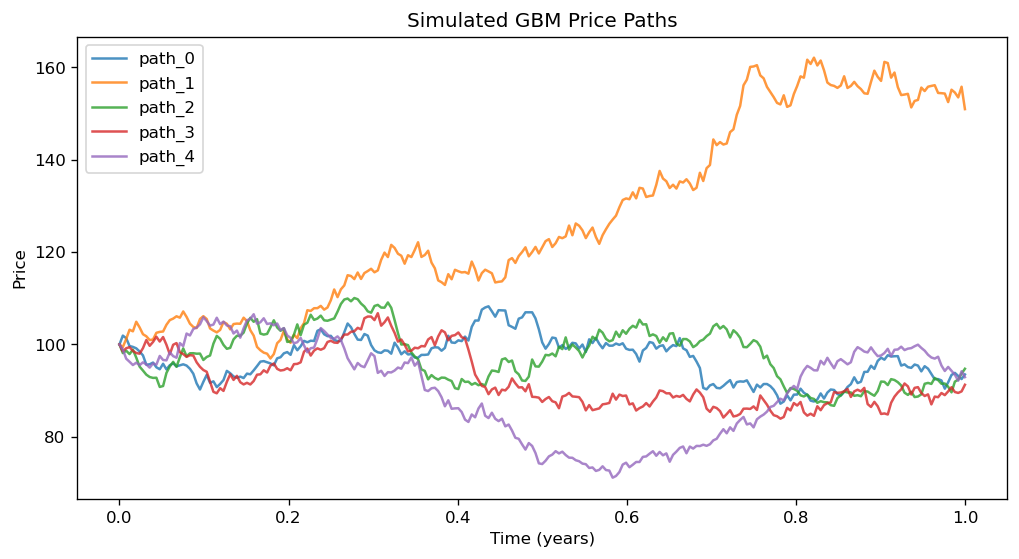

Final mean price: 104.67
Final std dev: 25.89
Total transaction cost: 12.63


In [44]:
# Inspect outputs
print("Simulated paths shape:", paths_df.shape)
print("Transaction costs shape:", tx_costs.shape)
display(paths_df.head())
display(tx_costs.head())

# Plot price paths
ax = paths_df.plot(legend=True, alpha=0.8)
ax.set_title("Simulated GBM Price Paths")
ax.set_xlabel("Time (years)")
ax.set_ylabel("Price")
plt.show()

# Summary statistics
final_prices = paths_df.iloc[-1]
print(f"Final mean price: {final_prices.mean():.2f}")
print(f"Final std dev: {final_prices.std(ddof=1):.2f}")
print(f"Total transaction cost: {tx_costs.sum():.2f}")

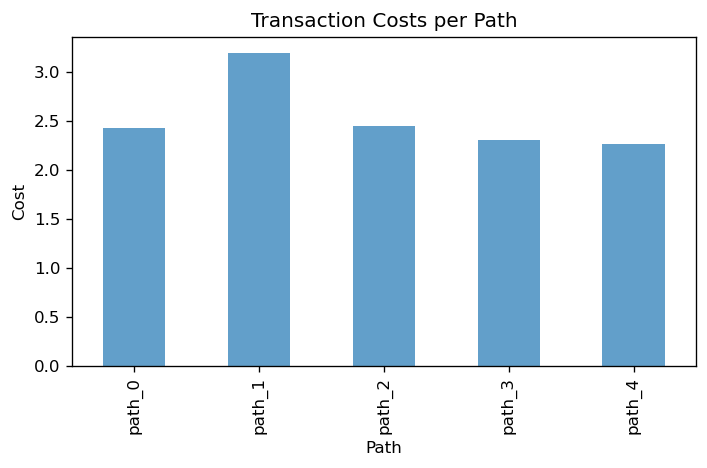

In [45]:
# Distribution of transaction costs
plt.figure(figsize=(6,4))
tx_costs.plot(kind="bar", alpha=0.7)
plt.title("Transaction Costs per Path")
plt.ylabel("Cost")
plt.xlabel("Path")
plt.tight_layout()
plt.show()

In [46]:
final_prices = paths_df.iloc[-1]
print(f"Final mean price: {final_prices.mean():.2f}")
print(f"Final price standard deviation: {final_prices.std(ddof=1):.2f}")
print(f"Total transaction cost: {tx_costs.sum():.2f}")

Final mean price: 104.67
Final price standard deviation: 25.89
Total transaction cost: 12.63
